In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pymorphy2-0.9.1-py3-none-any.whl (55 kB)


In [ ]:
!pip install bigartm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached bigartm-0.9.2-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (2.1 MB)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/

/content/drive/MyDrive


## Библиотеки

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import  pandas as pd
import seaborn as sns
import pymorphy2
import torch
import scipy
from sklearn.utils import shuffle
import re

import artm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

## Загружаем данные

In [ ]:
data = pd.read_csv('lenta-ru-proccess.csv')

In [ ]:
data

,text,tags,len,date
0,1 сентябрь весь территория россия вводиться но...,Все,1654,31-08-1999
1,"сведение миссия оон , передаваемый риа "" новос...",Все,1086,31-08-1999
2,15 представитель национал - большевистский пар...,Все,1219,31-08-1999
3,наметить сегодняшний день церемония вступление...,Все,3094,31-08-1999
4,"юг киргизия , именно баткенский чон - алайском...",Все,1354,31-08-1999
...,...,...,...,...
863280,популярный место среди турист мурманский облас...,Россия,1231,11-09-2020
863281,рейтинг международный рейтинговый агентство s ...,NaN,1425,11-09-2020
863282,российский учёный найти якутия новый подвид ар...,События,1299,11-09-2020
863283,указание коронавирус причина смерть человек не...,Общество,2061,11-09-2020


## BigARTM

### Перевод данных в формат данных для bigartm (+ деление на train/valid)

In [ ]:
filename_valid = ('texts_valid.vw.txt')
filename_train = ('texts_train.vw.txt')

In [ ]:
counter_train = 0
counter_valid = 0

y_train = []
y_valid = []

reg = re.compile(r'\W+')
with open(filename_valid, 'w') as fout_valid:
    with open(filename_train, 'w') as fout_train:
        for i in tqdm(range(len(data))):
            text = (reg.sub(' ', data.loc[i]['text']).strip()).split()
            label = data.loc[i]['tags']


            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write('doc_{} {} |@tags class_{}\n'.format(
                        counter_train, ' '.join(text), label))
                    counter_train += 1
                    y_valid.append(str('_'.join(data.loc[i]['date'].split('-')[1:])).lower().strip())
                else:
                    fout_train.write('doc_{} {} |@tags class_{}\n'.format(
                        counter_valid, ' '.join(text), label))
                    counter_valid += 1
                    y_train.append(str('_'.join(data.loc[i]['date'].split('-')[1:])).lower().strip())                    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/863285 [00:00<?, ?it/s]

In [ ]:
with open('y_valid.vw.txt', 'w') as f:
    f.write('\n'.join(y_valid))

with open('y_train.vw.txt', 'w') as f:
    f.write('\n'.join(y_train))

### Посмотрим на данный формат данных

In [ ]:
!head -2 texts_valid.vw.txt

doc_0 причина смерть меньший мера 34 малазийский ребёнок возраст 5 месяц 7 год стать неизвестный вирус вызывающий прекращение деятельность сердце мозг утверждать учёный проводить свой исследование страна это сегодня утром сообщить радиостанция ввс первоначально предполагаться причина смерть стать давно известный врач сезонный лихорадка однако поздний выясниться сердце мозг ребёнок поразить неизвестный вирус наблюдение пациент госпиталь субить опубликовать исследователь журнал the lancet доказать большинство умерший ребёнок развиться миокардит воспаление мозг вызвать сезонный лихорадка возбудитель болезнь признанный аденовирус назвать учёный agent y правило аденовирус опасный жизнь вызывать нетяжелый заболевание тип известный простуда однако именно agent y обнаружить исследование ткань сердце мозг погибший ребёнок учёный вынудить признать видимо речь идти новый разновидность вирус возникнуть южный азия утверждение bbc вспышка похожий заболевание произойти 1998 год тайвань |@tags class_В

In [ ]:
!head -2 y_valid.vw.txt

09_1999
09_1999


In [ ]:
!wc -l texts_valid.vw.txt

6604 texts_valid.vw.txt


In [ ]:
!head -2 texts_train.vw.txt

doc_0 1 сентябрь весь территория россия вводиться новый форма таможенный декларация физический лицо пояснить государственный таможенный комитет гтк форма декларация который одобрить совет руководитель таможенный служба государство участник содружество являться единый территория весь страна снг исключение армения данные итар тасс новый декларация содержаться подробный перечень товар подлежащее обязательный декларирование впервые число включить ядовитый сильно действующий вещество лекарство радиоактивный материал объект флор фауна также высокочастотный радио электронный устройство средство связь частность система радиолокация кабельный телевидение средство мобильный связь частота выше 9 килогерц кроме декларация необходимый приводить подробный сведение ввозить вывозить транспортный средство вид машинs год выпуск объесть двигатель номер двигатель кузов шасси россия новый форма декларация наряду прежний применяться 1 август лишь московский таможенный пункт шереметьево внуково домодедово чк

In [ ]:
!head -2 y_train.vw.txt

08_1999
08_1999


In [ ]:
!wc -l texts_train.vw.txt

653795 texts_train.vw.txt


### Создаем батчи

In [ ]:
bv_train = artm.BatchVectorizer(
    data_path=filename_train, data_format='vowpal_wabbit', batch_size=10000, 
    target_folder='batches_train', )

bv_test = artm.BatchVectorizer(
    data_path=filename_valid, data_format='vowpal_wabbit', batch_size=10000, 
    target_folder='batches_valid')


### Создаем словарь

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='batches_train')

#### Создание модели
Здесь поле tags как модальность

In [ ]:
model = artm.ARTM(num_topics=200,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0, 
                             '@tags': 10.0})

####Добавляем регуляторы

In [ ]:
model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@tags'))

####Обучение модели

In [ ]:
iterator = tqdm(range(5))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                          'sparsity': model.score_tracker['sparsity'].value[-1],})

  0%|          | 0/5 [00:00<?, ?it/s]

### Анализ метрик

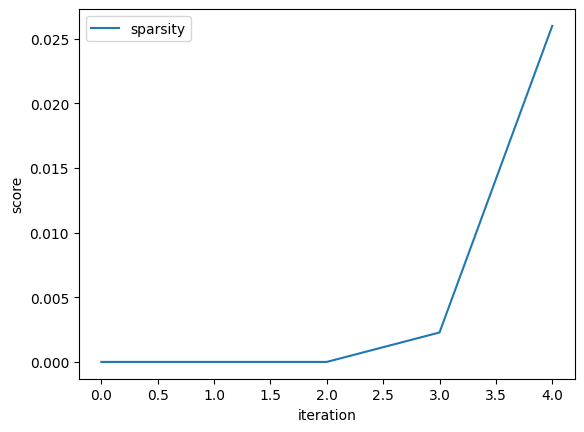

In [ ]:
plt.plot(model.score_tracker['sparsity'].value, label = 'sparsity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

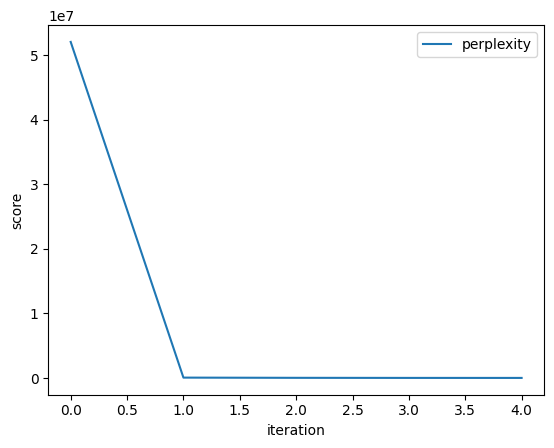

In [ ]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [ ]:
top_tokens = model.score_tracker['top-tokens'].last_tokens

for topic_name in model.topic_names:
    print(top_tokens[topic_name])

['законопроект', 'год', 'это', 'алкоголь', 'также', 'госдума', 'мочь', 'россия', 'пиво', 'страна']
['клуб', 'год', 'испания', 'барселона', 'футболист', 'миллион', 'реал', 'челси', 'испанский', 'манчестер']
['который', 'фотография', 'свой', 'снимка', 'человек', 'сеть', 'слово', 'фото', 'ресторан', 'также']
['оон', 'сша', 'который', 'страна', 'резолюция', 'российский', 'саммит', 'американский', 'президент', 'также']
['правительство', 'год', 'это', 'германия', 'принять', 'представитель', 'заявить', 'премьер', 'документ', 'время']
['рф', 'россия', 'это', 'дело', 'который', 'также', 'российский', 'заявить', 'гражданин', 'отношение']
['который', 'год', 'это', 'трансаэро', 'россия', 'сертификат', 'тысяча', 'компания', 'авиакомпания', 'также']
['год', 'это', 'газета', 'россия', 'власть', 'также', 'город', 'издание', 'однако', 'который']
['театр', 'год', 'спектакль', 'фестиваль', 'постановка', 'культура', 'который', 'опера', 'театральный', 'россия']
['который', 'немецкий', 'год', 'индия', 'герм

### Классификафия документы по месяцам

In [ ]:
X_train_pd = model.transform(bv_train)

In [ ]:
X_train_pd

,390000,390001,390002,390003,390004,390005,390006,390007,390008,390009,...,29990,29991,29992,29993,29994,29995,29996,29997,29998,29999
topic_0,0.000038,6.668428e-02,4.206426e-07,1.093939e-06,2.136680e-07,1.906093e-07,1.314737e-05,1.707063e-05,2.282887e-07,4.649370e-05,...,0.000005,8.328777e-07,7.471638e-06,0.000125,2.129676e-06,2.716945e-07,8.855907e-07,5.593019e-08,4.712083e-11,0.000376
topic_1,0.000013,2.414135e-07,3.609183e-06,5.534193e-09,6.587849e-08,7.168907e-07,5.403033e-07,5.666058e-07,2.285662e-05,3.909542e-05,...,0.018599,6.020508e-04,1.431353e-05,0.000028,2.029686e-07,2.839821e-06,2.884339e-02,3.190088e-07,6.166602e-07,0.000003
topic_2,0.000002,1.387503e-06,2.518765e-09,1.288300e-09,8.217004e-03,2.162562e-07,5.902043e-10,3.947418e-09,2.748077e-06,1.626640e-08,...,0.000356,5.072438e-08,1.527614e-07,0.021214,6.043151e-07,4.271633e-07,2.231321e-02,1.239824e-06,3.566054e-12,0.000014
topic_3,0.003441,1.866263e-04,1.023023e-04,6.018479e-07,1.760334e-07,3.159019e-05,1.360726e-06,4.331640e-05,8.840734e-07,2.407102e-05,...,0.000160,3.367255e-04,2.031780e-07,0.000573,8.713312e-06,2.143218e-05,7.001348e-05,2.241588e-06,3.759215e-10,0.001364
topic_4,0.002601,3.907854e-03,8.924361e-05,6.535639e-07,5.674510e-08,3.919814e-06,7.816878e-08,2.747881e-05,1.008193e-06,3.265344e-04,...,0.000015,1.796000e-04,1.830090e-05,0.000031,1.368110e-06,2.152743e-06,3.385168e-05,8.360063e-08,9.214254e-11,0.000679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
topic_195,0.000023,2.688325e-03,6.112351e-06,4.161576e-09,4.575115e-06,3.111140e-06,1.411793e-08,6.018319e-05,4.879397e-06,1.503283e-05,...,0.000634,1.030664e-03,3.586654e-04,0.000531,7.909479e-07,9.804031e-05,1.914162e-06,1.612436e-05,1.195585e-09,0.000225
topic_196,0.000045,2.226438e-07,4.228035e-07,3.557371e-07,8.192018e-08,3.515342e-08,1.339692e-05,2.176628e-07,1.877812e-05,2.695553e-04,...,0.000374,1.439514e-05,3.670483e-05,0.000078,6.242506e-08,2.303494e-08,9.148208e-09,3.154096e-09,7.225244e-06,0.000022
topic_197,0.000111,1.625060e-04,8.477072e-06,1.975467e-05,4.663144e-03,2.303950e-04,6.264995e-07,6.003694e-06,6.147419e-05,6.926501e-06,...,0.000734,8.559232e-05,3.588136e-04,0.000600,6.373176e-05,7.022768e-06,6.491813e-07,5.787320e-06,1.843589e-08,0.000338
topic_198,0.000632,2.199089e-06,4.979685e-06,6.406305e-05,3.407613e-06,6.738940e-05,5.827395e-07,9.053616e-05,1.041509e-06,2.603730e-05,...,0.000015,4.328380e-05,2.850967e-06,0.000003,5.102737e-06,5.669323e-07,1.819450e-06,3.008842e-07,6.120858e-11,0.027051


In [ ]:
with open('y_valid.vw.txt') as f:
    y_valid = f.read().split('\n')

with open('y_train.vw.txt') as f:
    y_train = f.read().split('\n')

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)

  0%|          | 0/653795 [00:00<?, ?it/s]

In [58]:
del X_train_pd

In [59]:
X_train, y_train = shuffle(X_train, y_train)

In [60]:
X_train = X_train[:20000]
y_train = y_train[:20000]

In [61]:
classifier = RandomForestClassifier(n_estimators=10)

In [62]:
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [63]:
X_valid_pd = model.transform(bv_test)

In [64]:
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

  0%|          | 0/6604 [00:00<?, ?it/s]

In [65]:
pred = classifier.predict(X_valid)

In [66]:
print(classification_report(y_valid, pred, zero_division=1))

              precision    recall  f1-score   support

     01_2000       0.00      0.00      0.00         5
     01_2001       0.00      0.00      0.00        11
     01_2002       0.00      0.00      0.00        10
     01_2003       0.00      0.00      0.00         9
     01_2004       0.00      0.00      0.00        13
     01_2005       0.01      0.06      0.02        18
     01_2006       0.00      0.00      0.00        24
     01_2007       0.00      0.00      0.00        16
     01_2008       0.01      0.10      0.02        21
     01_2009       0.02      0.09      0.03        32
     01_2010       0.00      0.00      0.00        30
     01_2011       0.01      0.09      0.02        23
     01_2012       0.02      0.10      0.03        30
     01_2013       0.01      0.03      0.01        34
     01_2014       0.01      0.06      0.02        31
     01_2015       0.00      0.00      0.00        28
     01_2016       0.00      0.00      0.00        33
     01_2017       0.02    